In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA

import gender_guesser.detector as gender

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# READ DATA

In [2]:
df = pd.read_csv('data/train.csv')
pd.set_option('display.max_columns', len(df.columns))
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
print(f"Total number of observations is {len(df)}")

Total number of observations is 8693


# MISSING DATA

<AxesSubplot:>

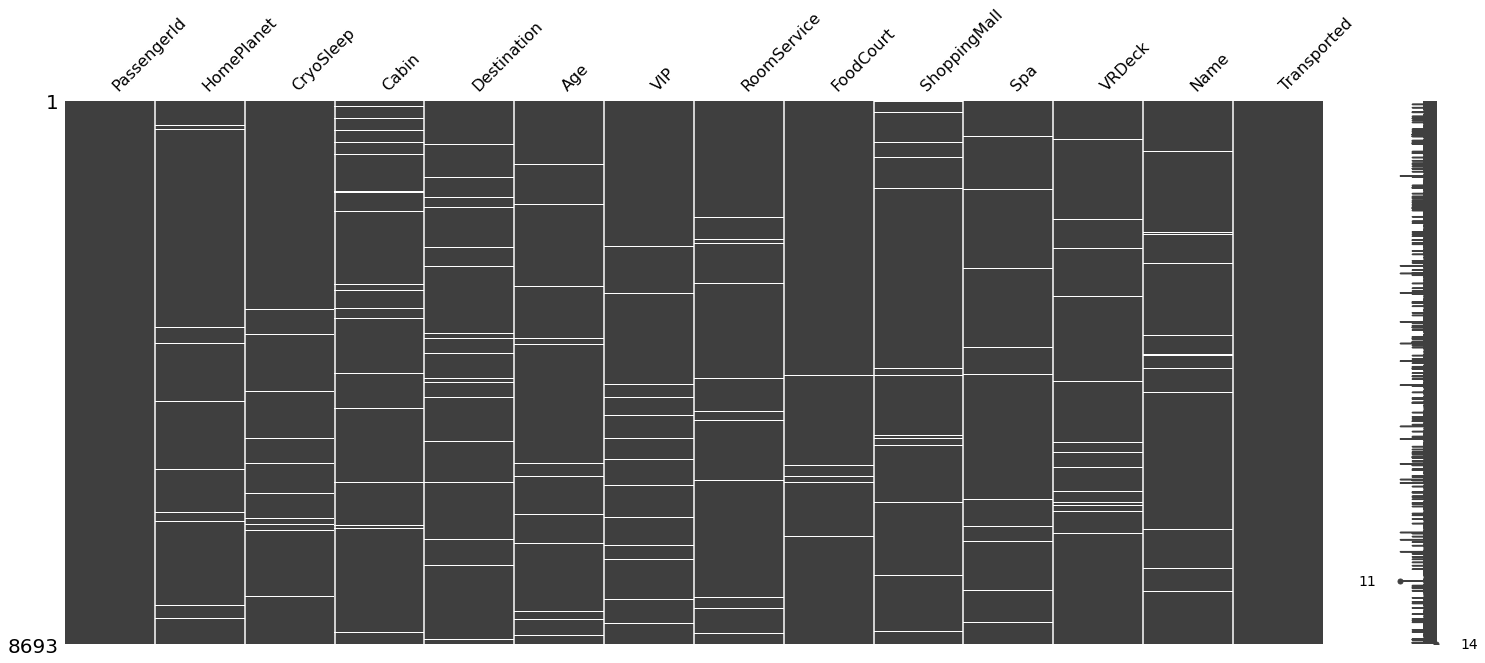

In [4]:
msno.matrix(df)

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
CryoSleep,217,0.024963
ShoppingMall,208,0.023927
VIP,203,0.023352
HomePlanet,201,0.023122
Name,200,0.023007
Cabin,199,0.022892
VRDeck,188,0.021627
FoodCourt,183,0.021051
Spa,183,0.021051
Destination,182,0.020936


In [6]:
df = df.dropna()
print(f"New number of observations is {len(df)}")

New number of observations is 6606


# DATA CLEANING

In [7]:
df['Transported'] = df['Transported'].astype(int)

In [8]:
def get_num_cat_var(df):
    num_var = list(df._get_numeric_data().columns)
    cat_var = list(set(df.columns) - set(num_var))
    
    return num_var, cat_var

num_var, cat_var = get_num_cat_var(df)

In [9]:
df[num_var].nunique().sort_values(ascending=False)

FoodCourt       1293
Spa             1143
VRDeck          1106
RoomService     1093
ShoppingMall     984
Age               80
Transported        2
dtype: int64

In [10]:
df[cat_var].nunique().sort_values(ascending=False)

PassengerId    6606
Name           6590
Cabin          5305
HomePlanet        3
Destination       3
CryoSleep         2
VIP               2
dtype: int64

In [11]:
df['Number'] = df['PassengerId'].apply(lambda x: int(x.split('_')[1]))
df = df.drop(['PassengerId'], axis=1)
num_var, cat_var = get_num_cat_var(df)

In [12]:
df[cat_var].nunique().sort_values(ascending=False)

Name           6590
Cabin          5305
HomePlanet        3
Destination       3
CryoSleep         2
VIP               2
dtype: int64

In [13]:
d = gender.Detector()
df['Gender'] = df['Name'].apply(lambda x: d.get_gender(x.split()[0]))
df = df.drop(['Name'], axis=1)
num_var, cat_var = get_num_cat_var(df)

In [14]:
df[cat_var].nunique().sort_values(ascending=False)

Cabin          5305
Gender            6
HomePlanet        3
Destination       3
CryoSleep         2
VIP               2
dtype: int64

In [15]:
df['Cabin deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
df['Cabin side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
df = df.drop(['Cabin'], axis=1)
num_var, cat_var = get_num_cat_var(df)

In [16]:
df[cat_var].nunique().sort_values(ascending=False)

Cabin deck     8
Gender         6
HomePlanet     3
Destination    3
CryoSleep      2
VIP            2
Cabin side     2
dtype: int64

In [17]:
df[num_var].nunique().sort_values(ascending=False)

FoodCourt       1293
Spa             1143
VRDeck          1106
RoomService     1093
ShoppingMall     984
Age               80
Number             8
Transported        2
dtype: int64

# CORRELATION

<AxesSubplot:>

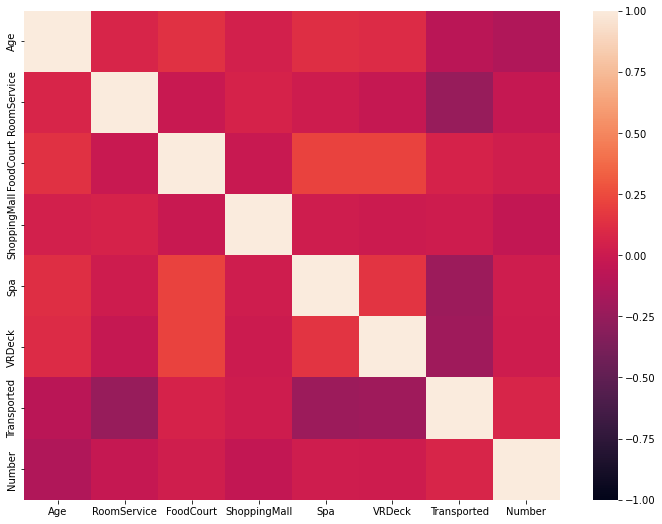

In [18]:
corr_mat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=1, vmin=-1)

# DATA EXPLORATION

In [19]:
df['Transported'].value_counts()

1    3327
0    3279
Name: Transported, dtype: int64

<AxesSubplot:>

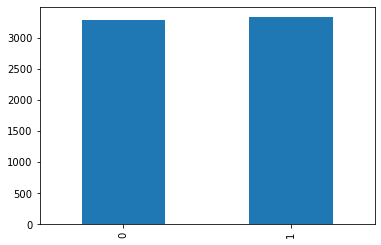

In [20]:
df['Transported'].value_counts().sort_values().plot(kind='bar')

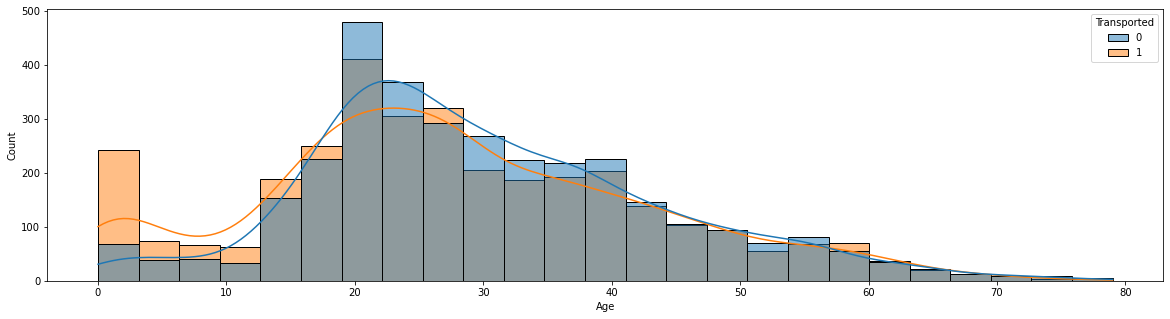

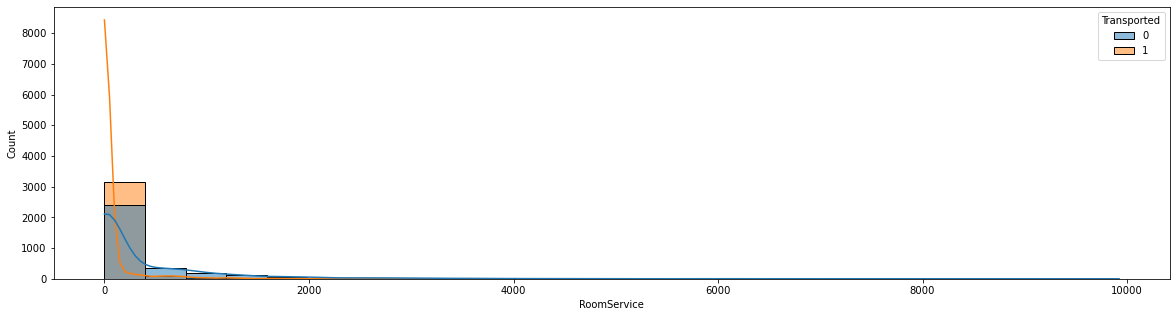

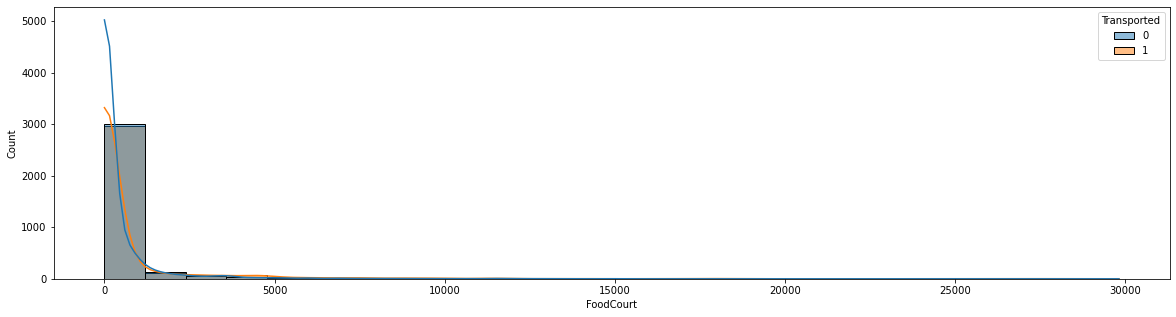

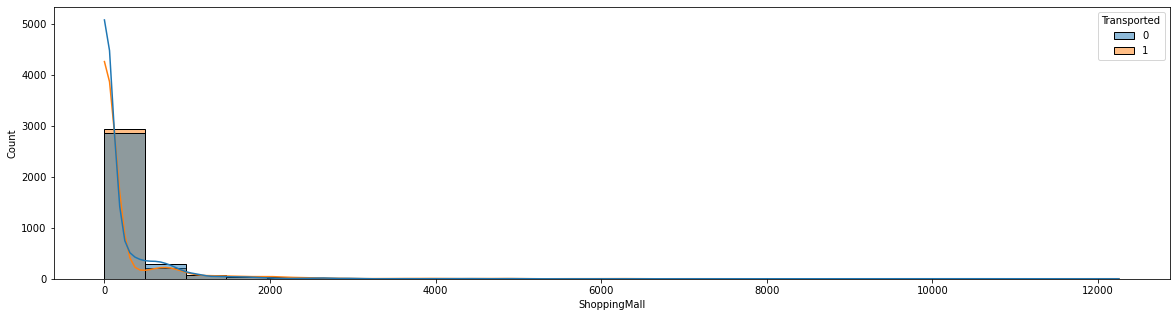

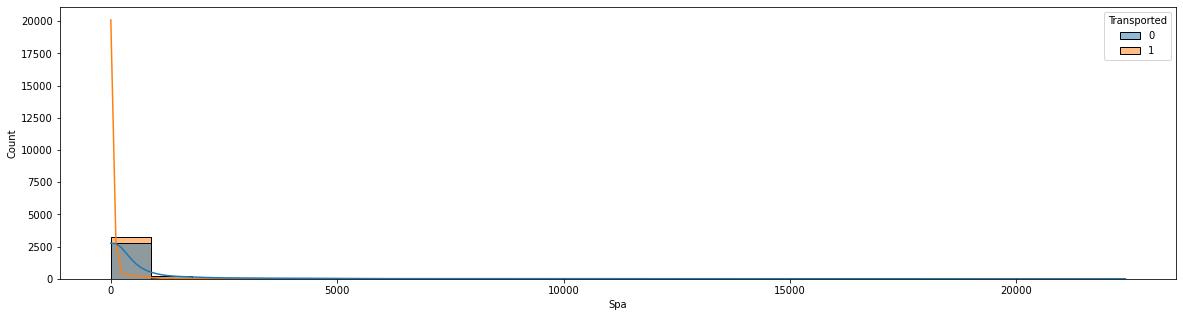

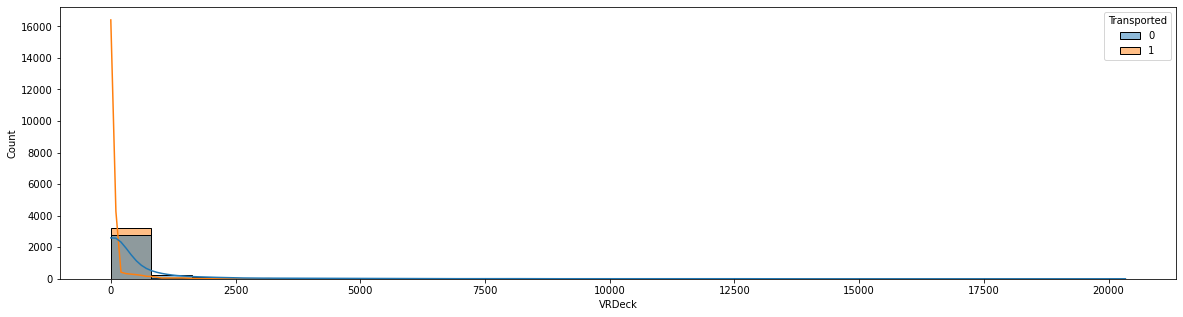

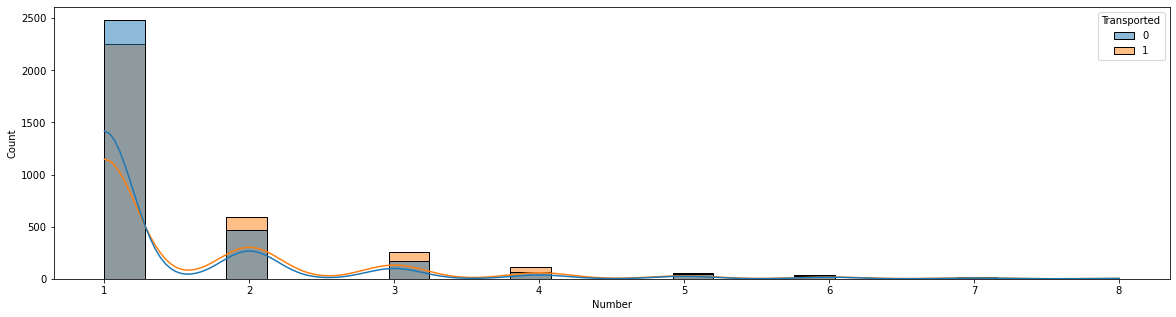

In [21]:
for var in num_var:
    if var != 'Transported':
        f, ax = plt.subplots(figsize=(20, 5))
        fig = sns.histplot(data=df, x=var, bins=25, kde=True, hue='Transported')

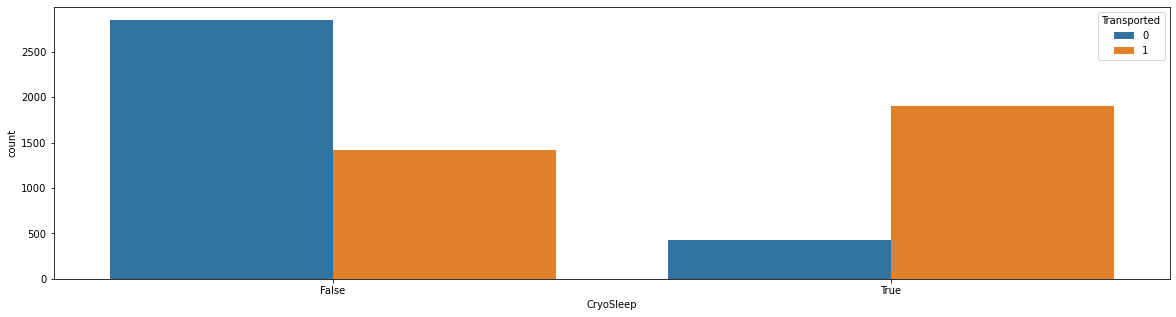

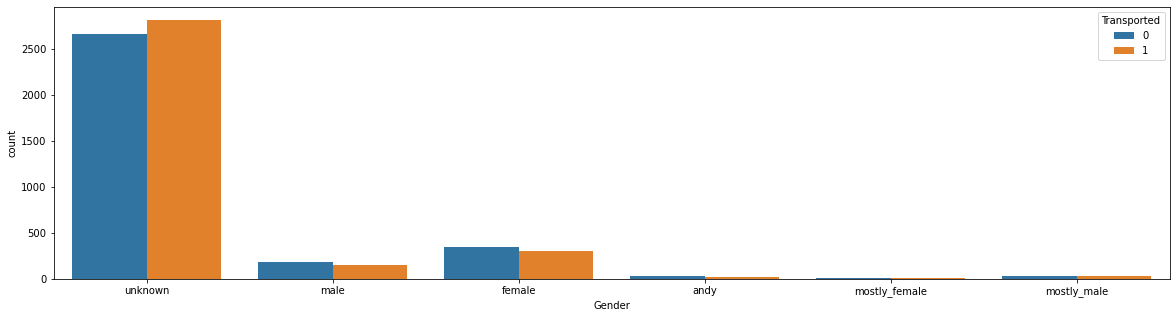

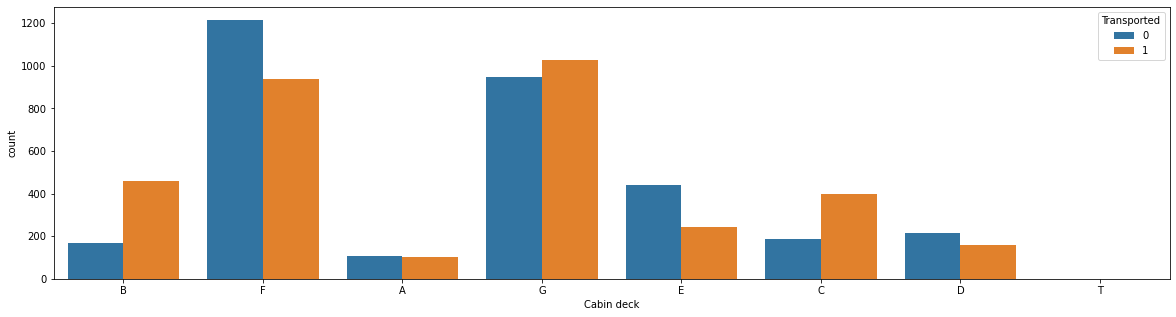

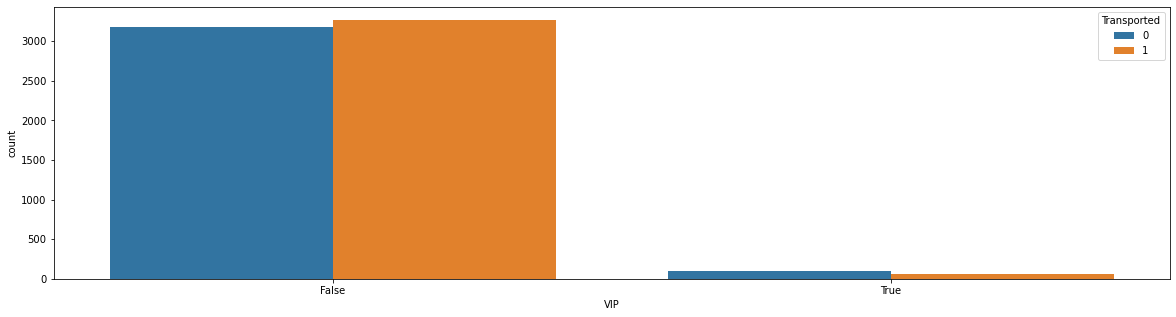

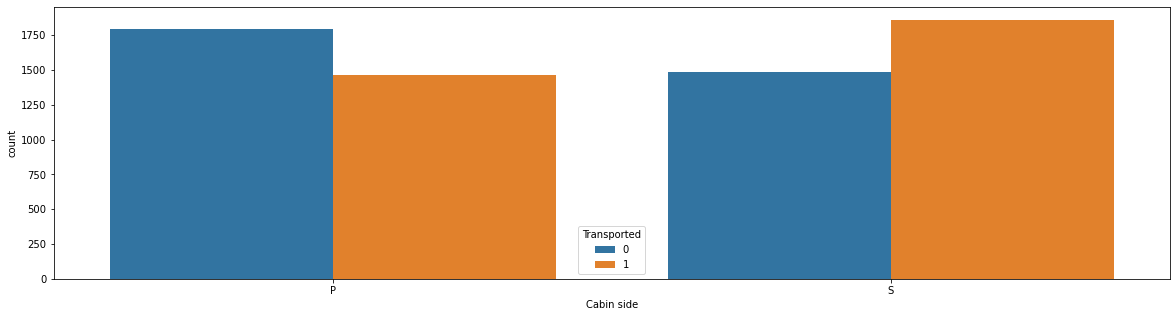

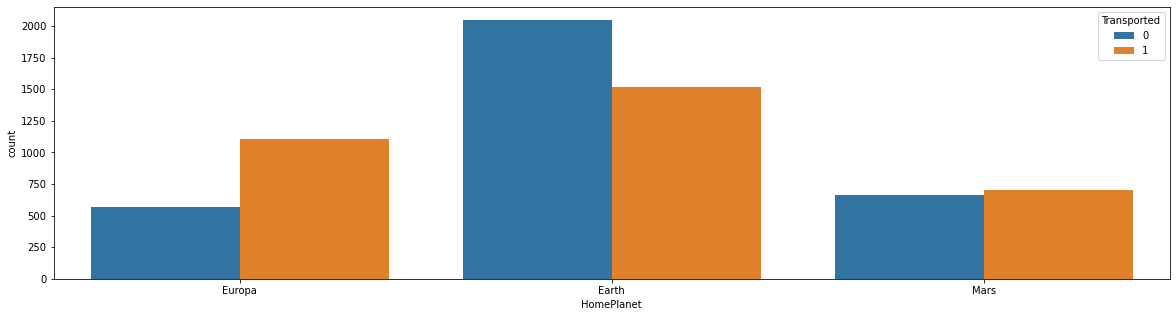

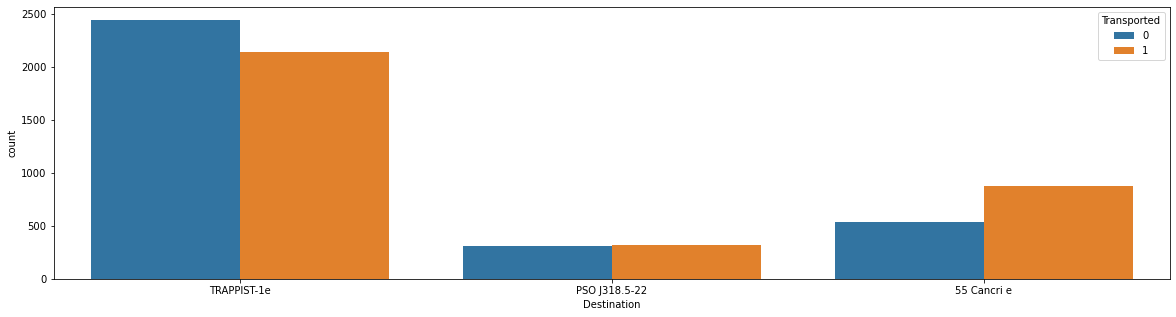

In [22]:
for var in cat_var:
    if var != 'Transported':
        f, ax = plt.subplots(figsize=(20, 5))
        fig = sns.countplot(data=df, x=var, hue='Transported')

# DATA PREPARATION

In [23]:
pd.set_option('display.max_columns', len(df.columns))
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Number,Gender,Cabin deck,Cabin side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,1,unknown,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,1,unknown,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,1,unknown,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,2,unknown,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,1,male,F,S


In [24]:
df = pd.get_dummies(df)
pd.set_option('display.max_columns', len(df.columns))
df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Number,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Gender_andy,Gender_female,Gender_male,Gender_mostly_female,Gender_mostly_male,Gender_unknown,Cabin deck_A,Cabin deck_B,Cabin deck_C,Cabin deck_D,Cabin deck_E,Cabin deck_F,Cabin deck_G,Cabin deck_T,Cabin side_P,Cabin side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,2,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [25]:
y = df[['Transported']]
X = df.drop('Transported', axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['Transported'], random_state=42)

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Gender_andy,Gender_female,Gender_male,Gender_mostly_female,Gender_mostly_male,Gender_unknown,Cabin deck_A,Cabin deck_B,Cabin deck_C,Cabin deck_D,Cabin deck_E,Cabin deck_F,Cabin deck_G,Cabin deck_T,Cabin side_P,Cabin side_S
0,0.280747,-0.342297,-0.263556,-0.299472,-0.274524,2.517793,-0.492608,-1.076745,1.727691,-0.518919,0.741630,-0.741630,1.933653,-0.321858,-1.509950,0.146484,-0.146484,-0.092679,-0.321141,-0.234759,-0.056812,-0.100657,0.448533,5.622925,-0.322931,-0.306587,-0.250502,-0.342580,-0.691705,-0.65607,-0.019459,1.005694,-1.005694
1,0.625019,1.909566,-0.286602,0.758795,-0.275405,-0.272281,-0.492608,-1.076745,-0.578807,1.927083,0.741630,-0.741630,-0.517156,-0.321858,0.662273,0.146484,-0.146484,-0.092679,-0.321141,-0.234759,-0.056812,-0.100657,0.448533,-0.177843,-0.322931,-0.306587,-0.250502,2.919027,-0.691705,-0.65607,-0.019459,-0.994339,0.994339
2,1.175855,-0.342297,-0.286602,-0.299472,-0.275405,-0.272281,0.445389,-1.076745,1.727691,-0.518919,-1.348382,1.348382,-0.517156,-0.321858,0.662273,0.146484,-0.146484,-0.092679,-0.321141,-0.234759,-0.056812,-0.100657,0.448533,-0.177843,3.096640,-0.306587,-0.250502,-0.342580,-0.691705,-0.65607,-0.019459,-0.994339,0.994339
3,-0.476651,0.102591,-0.047047,-0.299472,-0.275405,-0.269638,-0.492608,0.928725,-0.578807,-0.518919,0.741630,-0.741630,1.933653,-0.321858,-1.509950,0.146484,-0.146484,-0.092679,-0.321141,-0.234759,-0.056812,-0.100657,0.448533,-0.177843,-0.322931,-0.306587,-0.250502,-0.342580,1.445703,-0.65607,-0.019459,1.005694,-1.005694
4,-0.614360,-0.252405,-0.286602,2.461079,1.183715,-0.272281,-0.492608,-1.076745,-0.578807,1.927083,0.741630,-0.741630,-0.517156,-0.321858,0.662273,0.146484,-0.146484,-0.092679,-0.321141,-0.234759,-0.056812,-0.100657,0.448533,-0.177843,-0.322931,-0.306587,3.991979,-0.342580,-0.691705,-0.65607,-0.019459,1.005694,-1.005694


<AxesSubplot:>

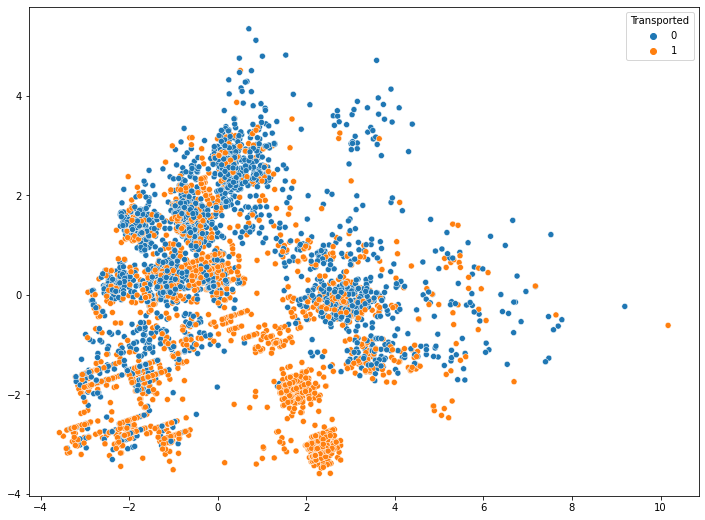

In [28]:
pca = PCA(n_components=2)
res = pca.fit_transform(X_train)

f, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(res[:,0], res[:,1], hue=y_train['Transported'])

# MACHINE LEARNING

## Random Forest

In [29]:
rfr = RandomForestClassifier(random_state=42)

param_grid = { 
    'max_depth' : list(np.linspace(2, 10, 10, dtype=int)),
    'n_estimators': list(np.linspace(100, 500, 10, dtype=int))
}

cv_rfc = RandomizedSearchCV(rfr, param_grid, n_iter=5, verbose=1)
cv_rfc.fit(X_train, y_train.values.ravel())

cv_rfc.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 500, 'max_depth': 8}

In [30]:
y_pred = cv_rfc.predict(X_test)
precision_rfc, recall_rfc, f1_score_rfc, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f'F1 score: {f1_score_rfc:.3f} | Precision: {precision_rfc:.3f} | Recall: {recall_rfc:.3f}')

F1 score: 0.784 | Precision: 0.796 | Recall: 0.773


<AxesSubplot:xlabel='Feature'>

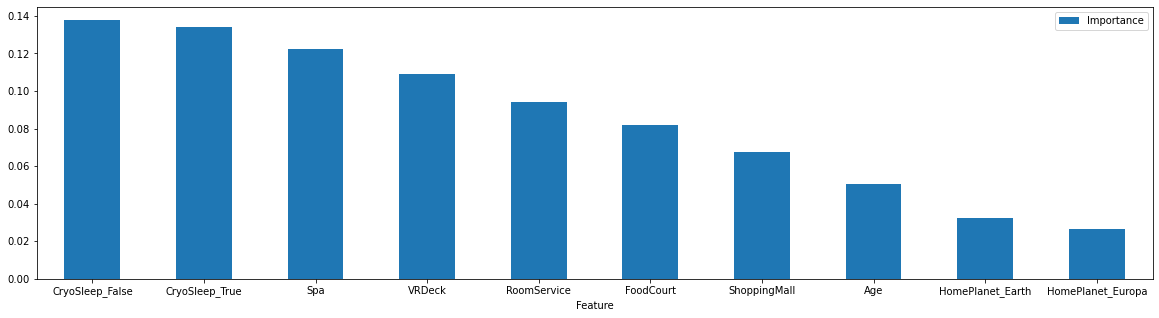

In [31]:
plt.rcParams["figure.figsize"] = (20, 5)

fi_rfc = pd.DataFrame(columns=['Feature', 'Importance'])
fi_rfc.Feature = X.columns
fi_rfc.Importance = cv_rfc.best_estimator_.feature_importances_
sorted_fi_rfc = fi_rfc.sort_values(by='Importance', ascending=False).head(10)

sorted_fi_rfc.plot.bar(x='Feature', y='Importance', rot=0)

In [32]:
xgbc = XGBClassifier(random_state=42)

param_grid = {
    'max_depth' : list(np.linspace(3, 11, 5, dtype=int)),
    'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
    'learning_rate': list(np.linspace(0.01, 0.3, 5)),
    'colsample_bytree': list(np.linspace(0.5, 1, 5)),
    'subsample': list(np.linspace(0.6, 1, 5)),
}

cv_xgbc = RandomizedSearchCV(xgbc, param_grid, n_iter=5, verbose=1)
cv_xgbc.fit(X_train, y_train.values.ravel())

cv_xgbc.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[12:45:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Ex

{'subsample': 0.9,
 'n_estimators': 500,
 'max_depth': 11,
 'learning_rate': 0.01,
 'colsample_bytree': 1.0}

In [33]:
y_pred = cv_xgbc.predict(X_test)
precision_xgbc, recall_xgbc, f1_score_xgbc, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f'F1 score: {precision_xgbc:.3f} | Precision: {recall_xgbc:.3f} | Recall: {f1_score_xgbc:.3f}')

F1 score: 0.807 | Precision: 0.791 | Recall: 0.799


<AxesSubplot:xlabel='Feature'>

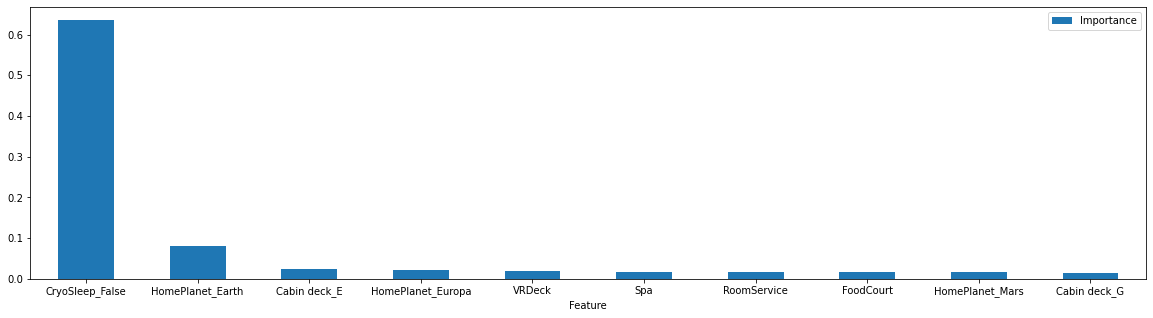

In [34]:
plt.rcParams["figure.figsize"] = (20, 5)

fi_xgbc = pd.DataFrame(columns=['Feature', 'Importance'])
fi_xgbc.Feature = X.columns
fi_xgbc.Importance = cv_xgbc.best_estimator_.feature_importances_
sorted_fi_xgbc = fi_xgbc.sort_values(by='Importance', ascending=False).head(10)

sorted_fi_xgbc.plot.bar(x='Feature', y='Importance', rot=0)